# Visualize per-pixel lighting

In [1]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib widget

# borrowed from Total3D repo -> notebooks/parse_OR_labels-lighting-reindexed%2Bassigned-V4.ipynb
import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')

import os
import json

%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib widget

dataset = 'OR'

mode = 'val'

split_path_dict = {'sunrgbd': 'data/sunrgbd/preprocessed', 'OR': '/home/ruizhu/Documents/Projects/semanticInverse/train/data/openrooms/list_OR_V4full/list'}

if dataset == 'sunrgbd':
    split_file = os.path.join(split_path_dict[dataset], mode + '.json')
    with open(split_file) as file:
        split = json.load(file)
elif dataset == 'OR':
    split_file = os.path.join(split_path_dict[dataset], mode + '.txt')
    with open(split_file) as f:
        mylist = f.read().splitlines() 
    split = [x.split(' ') for x in mylist]

print(len(split))

import torch
import numpy as np
from pathlib import Path
from utils.utils_total3D.utils_OR_visualize import format_layout, Box
from utils.utils_total3D.data_config import OR4XCLASSES_dict, NYU40CLASSES
from utils.utils_total3D.utils_others import OR4X_mapping_catInt_to_RGB, OR4X_mapping_catStr_to_RGB
from utils.utils_total3D.utils_OR_vis_labels import read_vis_scene_3d, RGB_to_01
import pickle
from icecream import ic

pickle_id = 0 # [!!! 0-based]

naming = split[pickle_id][2]
print(naming)

meta_split = naming.split('/')[0]
scene_name = naming.split('/')[1]
withinsequence_id = int(naming.split('/')[2].split('.')[0].split('_')[1])

5664
mainDiffLight_xml1/scene0509_00/im_1.hdr


## vis GT SG envmap

In [2]:
from pathlib import Path

root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
env_path = root_path / meta_split / scene_name / ('imenv_%d.hdr'%withinsequence_id)

import models_def.models_light as models_light 
import models_def.models_brdf as models_brdf # basic model

output2env = models_light.output2env(isCuda = True, envWidth = 16, envHeight = 8, SGNum = 12)


import os.path as osp
import numpy as np
import cv2
from skimage.measure import block_reduce 

envHeight = 8
envWidth = 16
envRow = 120
envCol = 160
SGNum = 12

def loadEnvmap(envName ):
    print('>>>>loadEnvmap', envName)
    if not osp.isfile(envName ):
        env = np.zeros( [3, envRow, envCol,
            envHeight, envWidth], dtype = np.float32 )
        envInd = np.zeros([1, 1, 1], dtype=np.float32 )
        print('Warning: the envmap %s does not exist.' % envName )
        return env, envInd
    else:
        envHeightOrig, envWidthOrig = 16, 32
        assert( (envHeightOrig / envHeight) == (envWidthOrig / envWidth) )
        assert( envHeightOrig % envHeight == 0)

        env = cv2.imread(envName, -1 ) 
        print(env.shape)

        if not env is None:
            env = env.reshape(envRow, envHeightOrig, envCol,
                envWidthOrig, 3) # (1920, 5120, 3) -> (120, 16, 160, 32, 3)
            env = np.ascontiguousarray(env.transpose([4, 0, 2, 1, 3] ) ) # -> (3, 120, 160, 16, 32)

            scale = envHeightOrig / envHeight
            if scale > 1:
                env = block_reduce(env, block_size = (1, 1, 1, 2, 2), func = np.mean )

            envInd = np.ones([1, 1, 1], dtype=np.float32 )
            return env, envInd
        else:
            env = np.zeros( [3, envRow, envCol,
                envHeight, envWidth], dtype = np.float32 )
            envInd = np.zeros([1, 1, 1], dtype=np.float32 )
            print('Warning: the envmap %s does not exist.' % envName )
            return env, envInd



# change to direct lighting; comment 3 lines to use original envmap lighting
# env_path = str(env_path).replace('imenv', 'imenvDirect')
# envRow = 120 // 4
# envCol = 160 // 4

envmaps_GT, envmapsInd = loadEnvmap(str(env_path))

# envmaps = aaaa.cpu().numpy().squeeze()

>>>>loadEnvmap /newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/mainDiffLight_xml1/scene0509_00/imenv_1.hdr
(1920, 5120, 3)


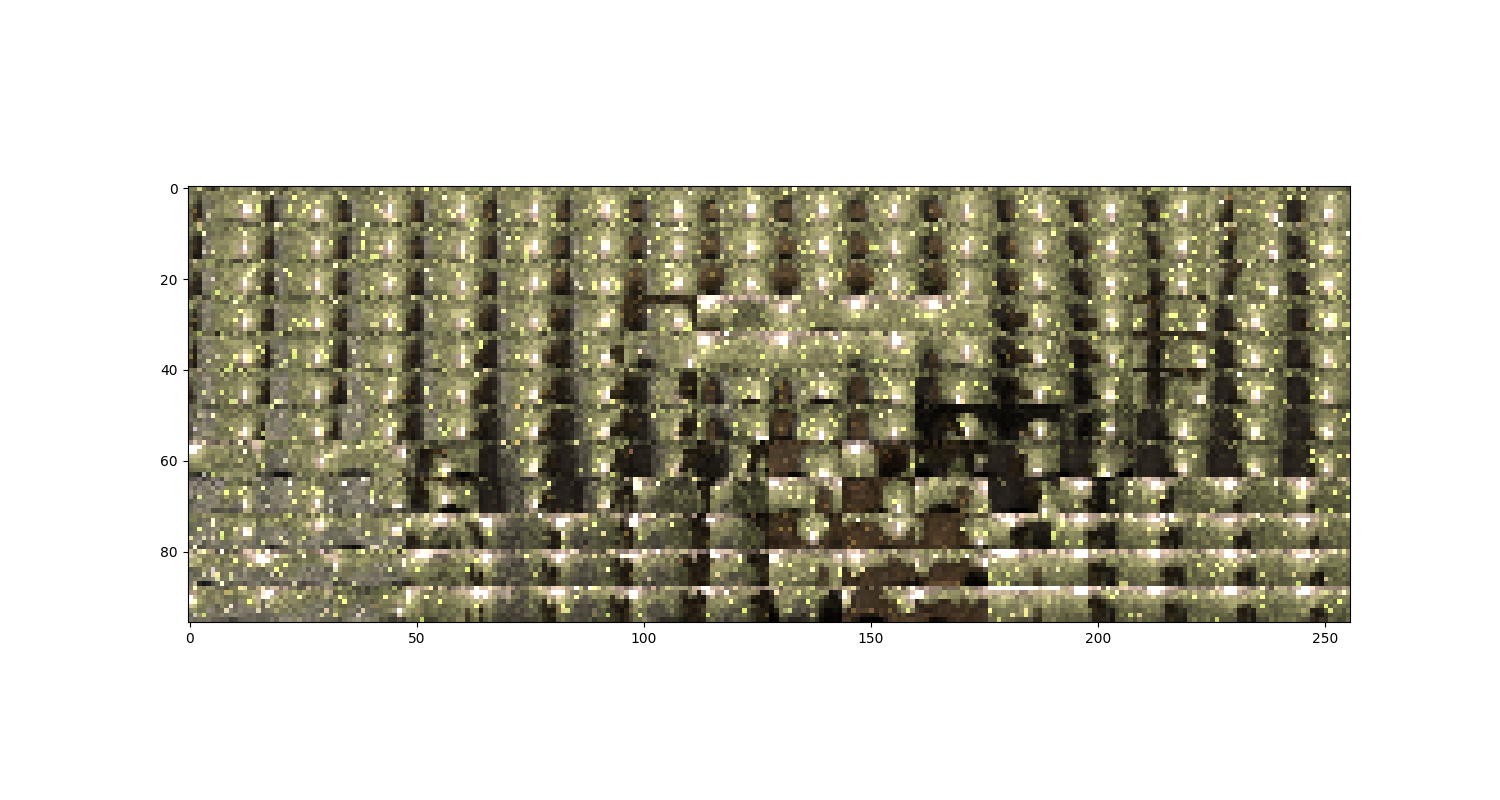

In [3]:
H_grid, W_grid, h, w = envmaps_GT.shape[1:]
downsize_ratio = 10
assert H_grid % downsize_ratio == 0
assert W_grid % downsize_ratio == 0
xx, yy = np.meshgrid(np.arange(0, H_grid, downsize_ratio), np.arange(0, W_grid, downsize_ratio))
a = envmaps_GT[:, xx.T, yy.T, :, :] * 0.05
a = np.clip(a**(1.0/2.2), 0., 1.)

# print(a.shape, a[0, 0, 0])
b = a.transpose(1, 3, 2, 4, 0).reshape(H_grid*h//downsize_ratio, W_grid*w//downsize_ratio, 3)

%matplotlib widget

plt.figure(figsize=(15, 8))
plt.imshow(b)
plt.show()

## render GT SG map using GT SG params

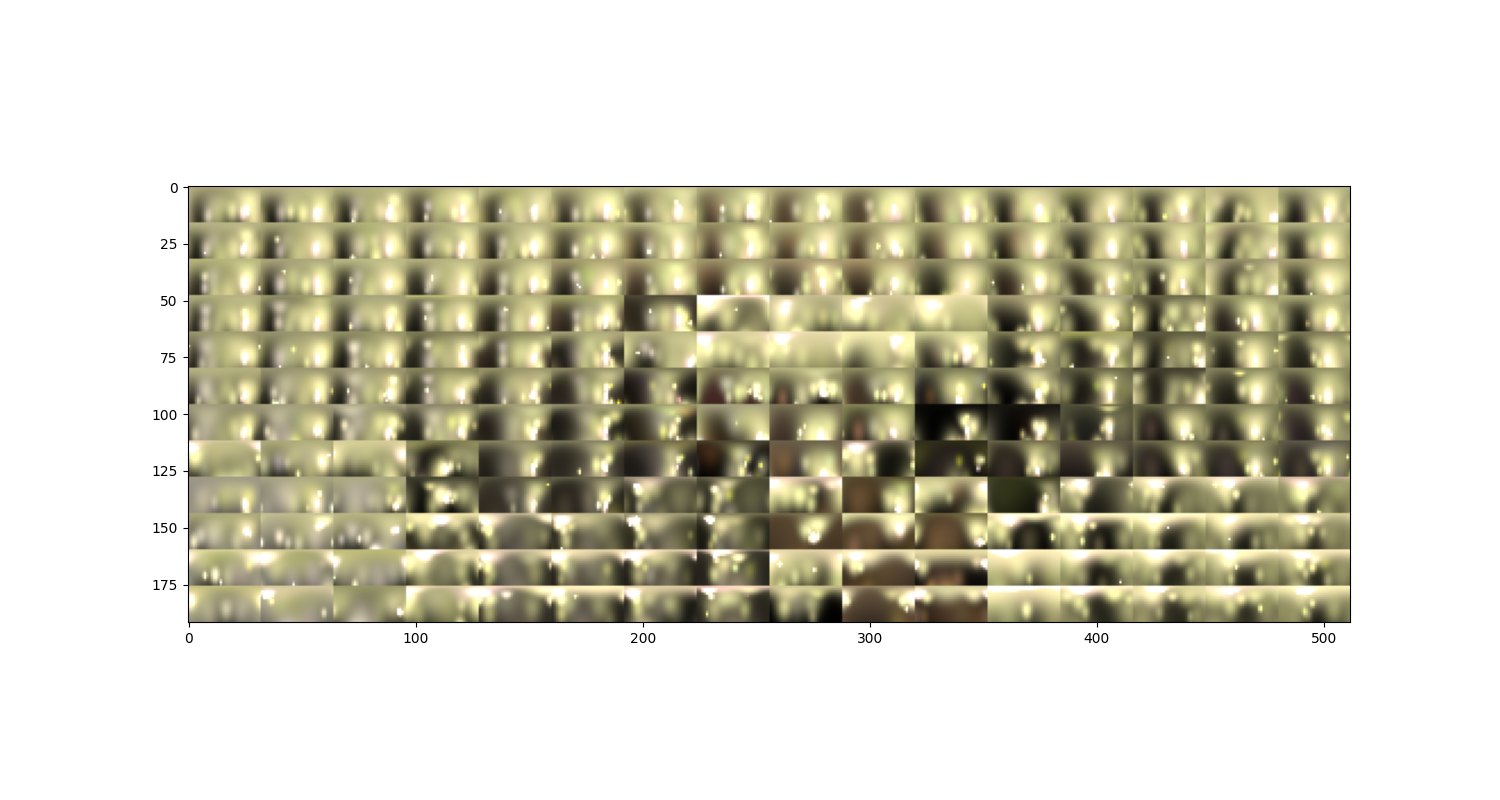

In [9]:
root_path = Path('/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/')
SG_label_path = root_path / meta_split / scene_name / ('imsgEnv_%d.h5'%withinsequence_id)

from utils.utils_io import loadH5
import torch

SG_label = loadH5(SG_label_path) # (120, 160, 12, 6)

# sg_single = SG_label[0, 0]
theta, phi, lamb, weight = np.split(SG_label, [1, 2, 3], axis=3)

SG_label_torch = torch.from_numpy(SG_label).cuda().view(-1, 12, 6)
theta_torch, phi_torch, lamb_torch, weight_torch = torch.split(SG_label_torch, [1, 1, 1, 3], dim=2)
# [!!!] the GT SG axes are in a camera-dependent local coords

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/third_parties_outside/SphericalGaussianOptimization')

import SGOptim

envRow = 120
envCol = 160
SGNum = 12
envHeight = 16
envWidth = 32

envNum = envRow * envCol

envOptim1 = SGOptim.SGEnvOptim(
    envNum = envNum,
    envWidth = envWidth,
    envHeight = envHeight,
    niter = 10, )


theta_torch = theta_torch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
phi_torch = phi_torch.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
lamb_torch = lamb_torch.unsqueeze(-1).unsqueeze(-1)
weight_torch = weight_torch.unsqueeze(-1).unsqueeze(-1)

# transform_axes_list = [camx.permute(1, 2, 0).view(-1, 3), camy.permute(1, 2, 0).view(-1, 3), normalPred.permute(1, 2, 0).view(-1, 3)]
recImage_GT = envOptim1.renderSG(theta_torch, phi_torch, lamb_torch, weight_torch) # [19200, 3, 8, 16]
# recImage = envOptim1.renderSG(theta_torch, phi_torch, lamb_torch, weight_torch, transform_axes_list=transform_axes_list) # [19200, 3, 8, 16]

recImage_GT = recImage_GT.view(envRow, envCol, 3, envHeight, envWidth).permute(2, 0, 1, 3, 4) # [3, 120, 160, 8, 16]
recImage_np_GT = recImage_GT.cpu().numpy()

H_grid, W_grid, h, w = recImage_GT.shape[1:]

a = recImage_np_GT[:, xx.T, yy.T, :, :] * 0.1
a = np.clip(a**(1.0/2.2), 0., 1.)
b = a.transpose(1, 3, 2, 4, 0).reshape(H_grid*h//downsize_ratio, W_grid*w//downsize_ratio, 3)

plt.figure(figsize=(15, 8))
plt.imshow(b)
plt.show()

In [21]:
np.median(weight)

3.936832

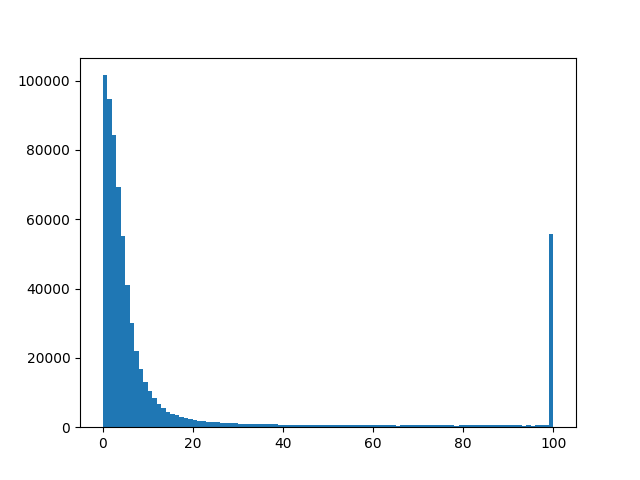

In [20]:
plt.figure()
weight0 = weight.copy()
weight0[weight0>100] = 100
plt.hist(weight0.flatten(), bins=100)
plt.show()

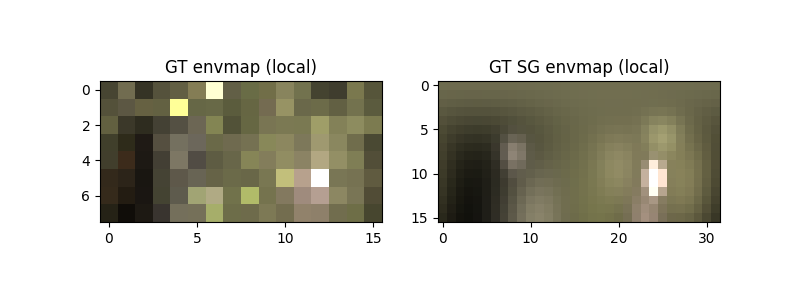

In [5]:
insertion_uv = [50, 50]

ii, jj = insertion_uv[1]//2, insertion_uv[0]//2

env_scale = 0.2
plt.figure(figsize=(8, 3))
ax = plt.subplot(121)
plt.imshow(np.clip(env_scale*envmaps_GT[:, ii, jj, :, :].transpose(1, 2, 0)**(1./2.2), 0., 1.))
ax.set_title('GT envmap (local)')
ax = plt.subplot(122)
plt.imshow(np.clip(env_scale*recImage_np_GT[:, ii, jj, :, :].transpose(1, 2, 0)**(1./2.2), 0., 1.))
ax.set_title('GT SG envmap (local)')
plt.show()

## transform to global LightNet/RAW coords

In [19]:
# import pickle

# results_folder = '20210516-235555-train_POD_jointEst-Emitter_Layout-diff-w10'; tid=0
# results_emitter_pickle_path = '/newfoundland2/ruizhu/semanticInverse_resources/Summary_vis_20210504/%s/results_emitter_%d.pickle'%(results_folder, pickle_id)
# with open(results_emitter_pickle_path, 'rb') as f:
#     results_emitter_dict = pickle.load(f)
# #     print(results_emitter_dict.keys())
# envmapsPredImage = torch.from_numpy(results_emitter_dict['envmapsPredImage']).cuda().unsqueeze(0)
# normalGT = torch.from_numpy(results_emitter_dict['normalGT']).cuda().unsqueeze(0)
normal_path = root_path / meta_split / scene_name / ('imnormal_%d.png'%withinsequence_id)
from utils.utils_io import loadImage
normalGT = loadImage(str(normal_path).replace('DiffLight', '').replace('DiffMat', ''), resize_HW=[240, 320])

normalGT_tensor = torch.from_numpy(normalGT).cuda().unsqueeze(0)
envmaps_GT_tensor = torch.from_numpy(envmaps_GT).cuda().unsqueeze(0)

from models_def.models_light import renderingLayer
rL = renderingLayer(imWidth = envCol, imHeight = envRow)
ls_coords, camx, camy, normalPred = rL.forwardEnv(normalGT_tensor, envmaps_GT_tensor, if_normal_only=True) # torch.Size([B, 128, 3, 120, 160]), [B, 3, 120, 160], [B, 3, 120, 160], [B, 3, 120, 160]
camx_reshape = camx.squeeze(0).permute(1, 2, 0).view(envNum, 1, 1, 1, 1, 3)
camy_reshape = camy.squeeze(0).permute(1, 2, 0).view(envNum, 1, 1, 1, 1, 3)
camz_reshape = normalPred.squeeze(0).permute(1, 2, 0).view(envNum, 1, 1, 1, 1, 3)

train_test_data_path = '/data/ruizhu/OR-V4full-withMesh20210510-assign2NotReindex-OR45_total3D_train_test_data'
transform_to_total3d_coords_dict_path = Path(train_test_data_path) / meta_split / scene_name / ('transform_to_total3d_coords_dict_%d.pkl'%withinsequence_id)
import pickle5 as pickle
with open(transform_to_total3d_coords_dict_path, 'rb') as f:
    transform_to_total3d_coords_dict = pickle.load(f)
transform_R, transform_t = transform_to_total3d_coords_dict['transform_R'], transform_to_total3d_coords_dict['transform_t']
transform_R_torch = torch.from_numpy(transform_R).cuda().float()
transform_t_torch = torch.from_numpy(transform_t).cuda().float()

# -------- ==> single envmap in global coords

axisX = torch.sin(theta_torch ) * torch.cos(phi_torch )
axisY = torch.sin(theta_torch ) * torch.sin(phi_torch )
axisZ = torch.cos(theta_torch )
axis_local_SG = torch.cat([axisX, axisY, axisZ], dim=5) # [19200, 12, 1, 1, 1, 3]; in a local SG (self.ls) coords

axis_LightNet = axis_local_SG[:, :, :, :, :, 0:1] * camx_reshape \
    + axis_local_SG[:, :, :, :, :, 1:2] * camy_reshape \
    + axis_local_SG[:, :, :, :, :, 2:3] * camz_reshape # transfer from a local camera-dependent coords to the ONE AND ONLY camera coords (LightNet)

axis_LightNet = .squeeze() # [19200, 12, 3]

# T_LightNet2Total3D_rightmult = results_emitter_dict['T_LightNet2Total3D_rightmult'].squeeze() # [3, 3]
# axis_Total3D = (axis_LightNet.unsqueeze(2)) @ (torch.from_numpy(T_LightNet2Total3D_rightmult).cuda().unsqueeze(0).unsqueeze(0))
# axis_Total3D = axis_Total3D.squeeze(2) # [19200, 12, 3]

# axis_RAW = (transform_R_torch.T.unsqueeze(0).unsqueeze(0)) @ (axis_Total3D.unsqueeze(-1))
# axis_RAW = axis_RAW.squeeze() # [19200, 12, 3]


tensor([0.1892, 0.7268, 0.6603], device='cuda:0')


In [29]:
ls_coords.shape

torch.Size([1, 128, 3, 120, 160])

## [obselete] render per-pixel lighting in RAW coords (outside envmap coords)
this does not work because you cannot transform all per-pixel lighting to one global project
https://i.imgur.com/LIiku0k.jpg

### all points

torch.Size([19200, 3, 16, 32])


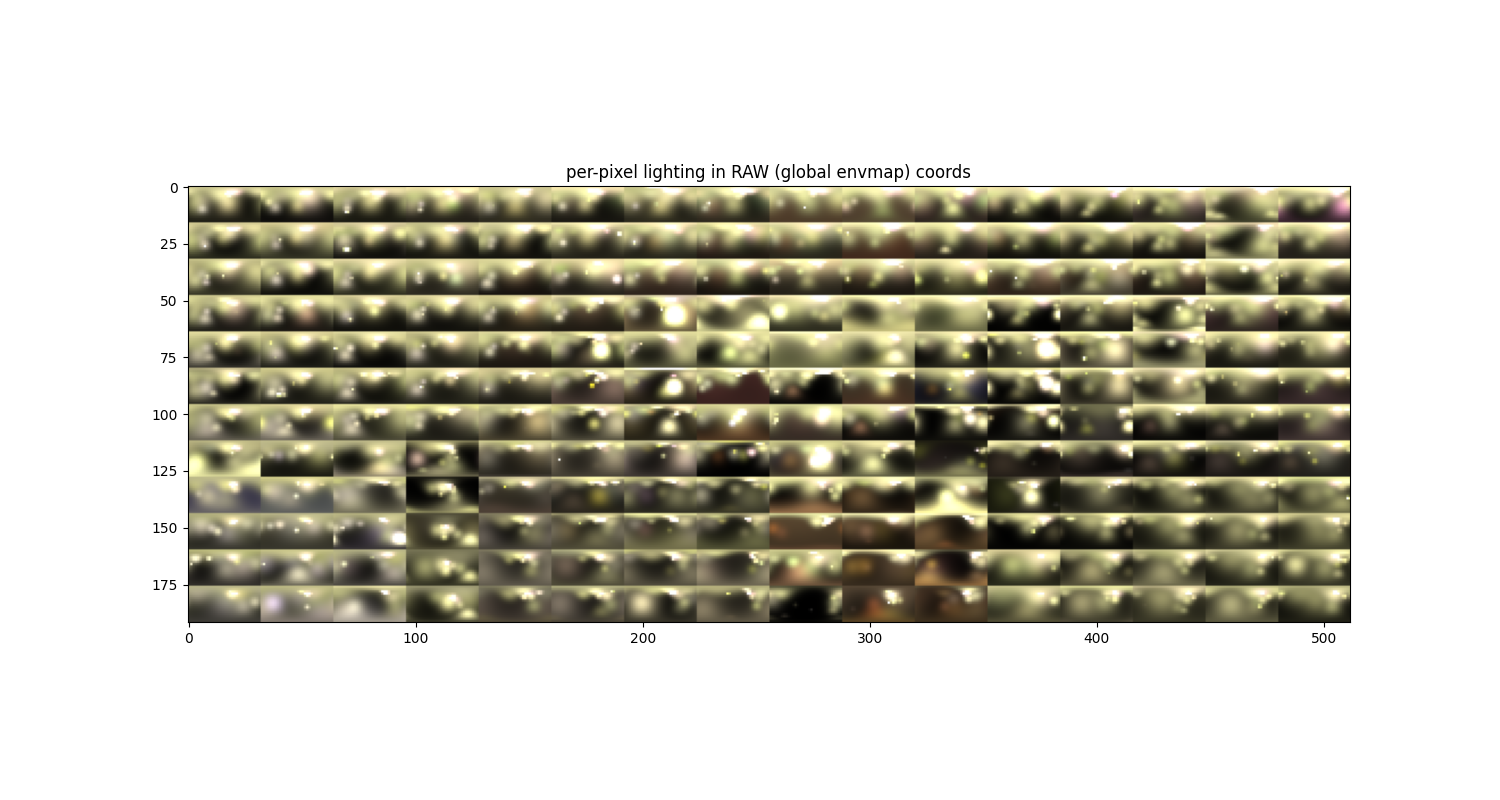

In [27]:
import SGOptim

envWidth_new = 32
envHeight_new = 16

envOptim1 = SGOptim.SGEnvOptim(
    envNum = envNum,
    envWidth = envWidth_new,
    envHeight = envHeight_new,
    if_full_sphere = True, # important!
    niter = 10, )

recImage_GT = envOptim1.renderSG(None, None, lamb_torch, weight_torch, axis_in=axis_LightNet.unsqueeze(2).unsqueeze(2).unsqueeze(2)) # [19200, 3, 8, 16]
print(recImage_GT.shape)
# recImage = envOptim1.renderSG(theta_torch, phi_torch, lamb_torch, weight_torch, transform_axes_list=transform_axes_list) # [19200, 3, 8, 16]

recImage_GT = recImage_GT.view(envRow, envCol, 3, envHeight_new, envWidth_new).permute(2, 0, 1, 3, 4) # [3, 120, 160, 8, 16]
recImage_np_GT = recImage_GT.cpu().numpy()

H_grid, W_grid, h, w = recImage_GT.shape[1:]

a = recImage_np_GT[:, xx.T, yy.T, :, :] * 0.1
a = np.clip(a**(1.0/2.2), 0., 1.)
b = a.transpose(1, 3, 2, 4, 0).reshape(H_grid*h//downsize_ratio, W_grid*w//downsize_ratio, 3)

plt.figure(figsize=(15, 8))
plt.imshow(b)
plt.title('per-pixel lighting in RAW (global envmap) coords')
plt.show()

### single point

torch.Size([1, 12, 1, 1, 1, 3]) tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], device='cuda:0')


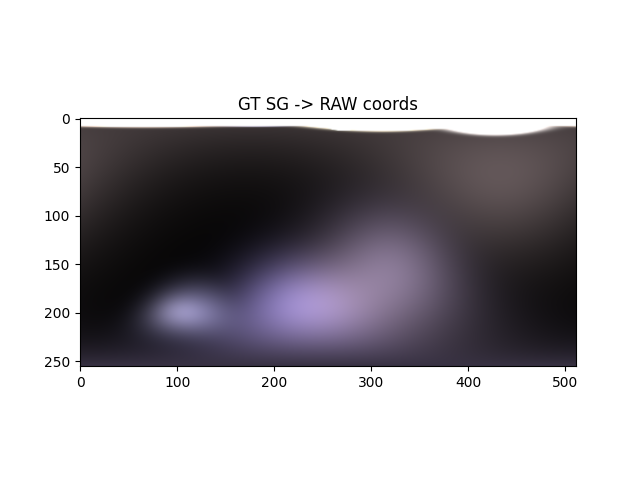

In [31]:
# insertion_uv = [150, 140]
insertion_uv = [220, 120]

ii, jj = insertion_uv[1]//2, insertion_uv[0]//2
axis_single_RAW = axis_RAW.view(envRow, envCol, SGNum, 1, 1, 1, 3)[ii, jj].unsqueeze(0) # [1, 12, 1, 1, 1, 3]
# print(axis_single_RAW.shape)
light_axis_world_SG = torch.cat([axis_single_RAW[:, :, :, :, :, 2:3], -axis_single_RAW[:, :, :, :, :, 0:1], axis_single_RAW[:, :, :, :, :, 1:2]], -1) # [1, 12, 1, 1, 1, 3]
print(light_axis_world_SG.shape, torch.linalg.norm(light_axis_world_SG, dim=-1).flatten())
light_axis_world_SG = light_axis_world_SG / torch.linalg.norm(light_axis_world_SG, axis=-1, keepdims=True)
# print(light_axis_world_SG.shape)

cos_theta = light_axis_world_SG[:, :, :, :, :, 2:3]
theta_SG_single = torch.acos(cos_theta) # [0, pi] # [1, 12, 1, 1, 1, 1]
cos_phi = light_axis_world_SG[:, :, :, :, :, 0:1] / torch.sin(theta_SG_single)
sin_phi = light_axis_world_SG[:, :, :, :, :, 1:2] / torch.sin(theta_SG_single)
phi_SG_single = torch.atan2(sin_phi, cos_phi) # [1, 12, 1, 1, 1, 1]

lamb_SG_single = lamb_torch.view(envRow, envCol, SGNum, 1, 1, 1, 1)[ii, jj].view(1, SGNum, 1, 1, 1)
weight_SG_single = weight_torch.view(envRow, envCol, SGNum, 1, 1, 1, 3)[ii, jj].view(1, SGNum, 3, 1, 1)
theta_single = theta_torch.view(envRow, envCol, SGNum, 1, 1, 1, 1)[ii, jj].view(1, SGNum, 1, 1, 1)

# weight_SG_single = weight_SG_single * (theta_single<=(np.pi/2.))

from utils.utils_total3D import SGOptim as SGOptimSky
envOptimSky = SGOptimSky.SGEnvOptimSky(weightValue=np.zeros(3,), thetaValue=0., phiValue=0., ambientValue=np.zeros(3,), \
                                       SGRow=1, SGCol=12, isCuda=True)
recImg_single = envOptimSky.renderSG(theta_SG_single, phi_SG_single, lamb_SG_single, weight_SG_single, \
                        ambient=torch.zeros((1, SGNum, 3, 1, 1)).cuda())
im_envmap_gen_single = recImg_single.cpu().numpy().squeeze().transpose(1, 2, 0)
env_scale = 0.5
im_envmap_gen_single = np.clip(im_envmap_gen_single**(1/2.2)*env_scale, 0., 1.)

plt.figure()
plt.imshow(im_envmap_gen_single)
plt.title('GT SG -> RAW coords')
plt.show()

## GT envmap optimize

In [18]:
env1 = torch.from_numpy(envmaps_GT).permute(1, 2, 0, 3, 4).cuda().view(envRow * envCol, 3, envHeight, envWidth )
mask1 = torch.ones(envRow * envCol, 1, 1, 1).cuda()
theta1, phi1, lamb1, weight1,  recImage1 = envOptim1.optimize(env1, mask1 )


Iteration 0
0 Loss: 0.985891
20 Loss: 0.145964
40 Loss: 0.117019
60 Loss: 0.099912
80 Loss: 0.090384
Iteration 1
100 Loss: 0.083946
120 Loss: 0.079045
140 Loss: 0.074970
160 Loss: 0.071596
180 Loss: 0.068618
Iteration 2
200 Loss: 0.066280
220 Loss: 0.064252
240 Loss: 0.062491
260 Loss: 0.060857
280 Loss: 0.059294
Iteration 3
300 Loss: 0.058020
320 Loss: 0.056855
340 Loss: 0.055771
360 Loss: 0.054749
380 Loss: 0.053735
Iteration 4
400 Loss: 0.052879
420 Loss: 0.052151
440 Loss: 0.051401
460 Loss: 0.050676
480 Loss: 0.049981
Iteration 5
500 Loss: 0.049372
520 Loss: 0.048823
540 Loss: 0.048278
560 Loss: 0.047748
580 Loss: 0.047258
Iteration 6
600 Loss: 0.046812
620 Loss: 0.046387
640 Loss: 0.045977
660 Loss: 0.045591
680 Loss: 0.045234
Iteration 7
700 Loss: 0.044874
720 Loss: 0.044553
740 Loss: 0.044220
760 Loss: 0.043891
780 Loss: 0.043599
Iteration 8
800 Loss: 0.043297
820 Loss: 0.043008
840 Loss: 0.042729
860 Loss: 0.042472
880 Loss: 0.042210
Iteration 9
900 Loss: 0.041983
920 Loss: 0.